Goal here is to check that the method in getDC2VisitList is ok.

Know: two circle overlap iff (R0-R1)^2 <= (x0-x1)^2+(y0-y1)^2 <= (R0+R1)^2

So the methodology adopted here is to model the DC2 footprint as a circle (in x, y; not ra, dec), and compare with circular FOVs.
- Ideally no fID should be present in the list found here, but not in those saved by getDC2VisitList.
- Those visits that turn out to not be in the visit list from getDC2VisitList code *must* be outside the footprint -- checked by producing the GIFs using DC2VisitsSim.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import healpy as hp
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")
import time
import pandas as pd

In [2]:
repoDir= os.getcwd()
print(repoDir)

/Users/humnaawan/repos/DC2_Repo/scripts/visitGen


In [3]:
regionCorners= {}
regionCorners['WFD']= [[57.87, -27.25], [58.02, -32.25], [52.11, -32.25], [52.25, -27.25]]
regionCorners['DD']= [[53.764, -27.533], [53.771, -28.667], [52.479, -28.667], [52.486, -27.533]]

In [4]:
center= {}
center['WFD']= [55.064, -29.783]
center['DD']= [53.125, -28.100]

In [5]:
# set up the circular footprints
radius= {}
circCenter_ra= {}
circCenter_dec= {}
for key in regionCorners.keys():    
    x1, y1= center[key][0]*np.cos(np.radians(center[key][1])), center[key][1]
    x2, y2= regionCorners[key][0][0]*np.cos(np.radians(regionCorners[key][0][1])), regionCorners[key][0][1]

    radius[key]= 0.7*np.sqrt((x2-x1)**2+(y2-y1))
    circCenter_ra[key], circCenter_dec[key]= x1/np.cos(np.radians(center[key][1])), y1

In [6]:
print(radius)
print(circCenter_ra)
print(circCenter_dec)

{'WFD': 2.7916065446999974, 'DD': 0.77515948181482386}
{'WFD': 55.064, 'DD': 53.125}
{'WFD': -29.783, 'DD': -28.1}


In [7]:
stepsize = np.pi/50.
theta = np.arange(0, np.pi*2.+stepsize, stepsize)

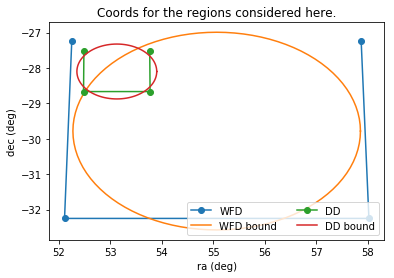

In [8]:
# plot the regions to check whats up
for key in regionCorners.keys():    
    xs, ys= [], []
    for x, y in regionCorners[key]:
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys, 'o-', label= key)

    # plot the circle
    delx= radius[key]*np.cos(theta)
    dely= radius[key]*np.sin(theta)

    plt.plot(delx+circCenter_ra[key], dely+circCenter_dec[key], '-', label= '%s bound'%key)

plt.legend(loc="lower right", ncol= 2)
plt.title('Coords for the regions considered here.')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.show()

In [9]:
# simdata datapath
mainDir= home+'/lsstData/'
dbpath= mainDir+'minion_1016_desc_dithered_v3.db'   # new afterburner output
pointingRACol= 'descDitheredRA'
pointingDecCol= 'descDitheredDec'

In [10]:
from DC2_visitListCode import getSimData
from DC2_visitsSim import DC2VisitsSim

In [11]:
# run the check on WFD, DD
foundHere= {}
for surveyRegionTag in regionCorners.keys():
    simData= getSimData(dbpath, surveyRegionTag, pointingRACol, pointingDecCol)

    FOVradius= np.degrees(0.0305)

    obsIDs, fIDs, bands= [], [], []
    for i, oid in enumerate(simData['obsHistID']):
        FOVra, FOVdec= simData[pointingRACol][i], simData[pointingDecCol][i]

        x0, y0= np.degrees(FOVra*np.cos(FOVdec)), np.degrees(FOVdec)
        x1, y1= circCenter_ra[surveyRegionTag]*np.cos(np.radians(circCenter_dec[surveyRegionTag])), circCenter_dec[surveyRegionTag] 
        # (R0-R1)^2 <= (x0-x1)^2+(y0-y1)^2 <= (R0+R1)^2
        middle= (x0-x1)**2+(y0-y1)**2
        if (middle>= (radius[surveyRegionTag]-FOVradius)**2) & (middle<= (radius[surveyRegionTag]+FOVradius)**2):
            obsIDs.append(oid)
            fIDs.append(simData['fieldID'][i])
            bands.append(simData['filter'][i])
                
    foundHere[surveyRegionTag]= pd.DataFrame({'obsHistID': np.array(obsIDs), 'fID': np.array(fIDs), 'band': np.array(bands)})

In [12]:
# run the check on WFD visits in uDD footprint
surveyRegionTag= 'WFD_inUDD'
simData= getSimData(dbpath, 'WFD', pointingRACol, pointingDecCol)

FOVradius= np.degrees(0.0305)

obsIDs, fIDs, bands= [], [], []
for i, oid in enumerate(simData['obsHistID']):
    FOVra, FOVdec= simData[pointingRACol][i], simData[pointingDecCol][i]

    x0, y0= np.degrees(FOVra*np.cos(FOVdec)), np.degrees(FOVdec)
    x1, y1= circCenter_ra['DD']*np.cos(np.radians(circCenter_dec['DD'])), circCenter_dec['DD'] 
    # want (R0-R1)^2 <= (x0-x1)^2+(y0-y1)^2 <= (R0+R1)^2
    middle= (x0-x1)**2+(y0-y1)**2
    if (middle>= (radius['DD']-FOVradius)**2) & (middle<= (radius['DD']+FOVradius)**2):
        obsIDs.append(oid)
        fIDs.append(simData['fieldID'][i])
        bands.append(simData['filter'][i])

foundHere[surveyRegionTag]= pd.DataFrame({'obsHistID': np.array(obsIDs), 'fID': np.array(fIDs), 'band': np.array(bands)})

#### Read in the save lists/pixels.

In [13]:
nside= 512

In [14]:
# where the data was saved form the visitList run.
outDir= '%s/../../protoDC2Visits_nside%s/'%(repoDir, nside)

In [15]:
# read in the visit list
saved= {}
csvFile= '%s/visitLists//DC2VisitList_minion1016_v3_WFDvisits_nside%s_WFDvisitsInWFD.csv'%(outDir, nside)
saved['WFD']= pd.read_csv(csvFile)

csvFile= '%s/visitLists//DC2VisitList_minion1016_v3_DDvisits_nside%s_DDvisitsInuDD.csv'%(outDir, nside)
saved['DD']= pd.read_csv(csvFile)

csvFile= '%s/visitLists//DC2VisitList_minion1016_v3_WFDvisits_nside%s_WFDvisitsInuDD.csv'%(outDir, nside)
saved['WFD_inUDD']= pd.read_csv(csvFile)

# read in the pixels nmbers
regionPixels= {}
csvFile= '%s/regionPixels//DC2RegionPixels_minion1016_v3_WFDvisits_nside%s_WFDvisitsInWFD.csv'%(outDir, nside)

regionPixels['WFD']= pd.read_csv(csvFile)['regionPixels']

csvFile= '%s/regionPixels//DC2RegionPixels_minion1016_v3_DDvisits_nside%s_DDvisitsInuDD.csv'%(outDir, nside)

regionPixels['DD']= pd.read_csv(csvFile)['regionPixels']

#### Compare

First compare the fIDs

In [16]:
for key in saved:
    missing= list(set(foundHere[key]['fID'])-set(saved[key]['fID']))
    nMissing= len(missing)
    print('\n%s: Number of fID that are found here that are not in the saved list: %s'%(key, nMissing))
    print('Missing fIDs: %s\n'%(missing))
    if (nMissing>0):
        for fid in missing:
            ind= np.where(np.array(foundHere[key]['fID'])==fid)[0]
            print('Number of visits that found here for fID= %s: %s\n%s'%(fid, len(ind),
                                                                             np.array(foundHere[key]['obsHistID'])[ind]))


WFD: Number of fID that are found here that are not in the saved list: 2
Missing fIDs: [1339, 1165]

Number of visits that found here for fID= 1339: 4
[ 648558  693454 1634983 1641526]
Number of visits that found here for fID= 1165: 39
[  37652  193271  219182  230739  414869  471934  510373  510392  708487
  720208  792810  899726  904820  924207  943328  994948 1154357 1165821
 1249314 1251697 1404998 1413746 1415972 1443883 1460545 1492284 1506595
 1643938 1660505 1661844 1695445 1716413 1734076 1903084 2016201 2137665
 2156561 2163266 2227626]

DD: Number of fID that are found here that are not in the saved list: 0
Missing fIDs: []


WFD_inUDD: Number of fID that are found here that are not in the saved list: 1
Missing fIDs: [1297]

Number of visits that found here for fID= 1297: 21
[  12456  181900  204560  291860  415031  420805  648549 1138155 1157696
 1161454 1272223 1407855 1433890 1471712 1527795 1690572 1694240 1975222
 2152058 2169474 2393669]


Ok some fIDs are found here that are not the saved lists. Check them:

In [17]:
# compile these missing visits
probObsIDs, probfIDs, probBands= {}, {}, {}
for key in ['WFD', 'WFD_inUDD']:
    missing= list(set(foundHere[key]['fID'])-set(saved[key]['fID']))
    for fid in missing:
        ind= np.where(np.array(foundHere[key]['fID'])==fid)[0]
        missingObsID= np.unique(np.array(foundHere[key]['obsHistID'])[ind])

        probOID, probfID, probBand= [], [], []
        for i, oid in enumerate(missingObsID):
            probOID.append(oid)
            probfID.append(fid)
            ind= np.where(np.array(foundHere[key]['obsHistID'])== oid)[0]

            probBand.append(np.array(foundHere[key]['band'])[ind][0])

        obsIDs, fIDs, bands= np.array(probOID), np.array(probfID), np.array(probBand)
        obsIDs, ind= np.unique(obsIDs, return_index= True)
        fIDs, bands= fIDs[ind], bands[ind]
    
    probObsIDs[key], probfIDs[key], probBands[key]= obsIDs, fIDs, bands

In [18]:
ras, decs= [], []
for key in regionCorners:
    for i in regionCorners[key]:
        ras.append(i[0])
        decs.append(i[1])
    
minRA, maxRA= min(ras), max(ras)
minDec, maxDec= min(decs), max(decs)

In [19]:
# simData is for WFD
surveyRegionTag= 'WFD'
DC2VisitsSim(outDir+'gifs_checks/', 'WFD_fid_test', simData, pointingRACol, pointingDecCol,
                 probObsIDs[surveyRegionTag], probfIDs[surveyRegionTag], probBands[surveyRegionTag],
                 regionPixels_WFD= regionPixels['WFD'], regionPixels_DD= regionPixels['DD'],
                 nside= 512,
                 obsHistIndMin= 0, obsHistIndMax= -1,
             minRA= minRA, maxRA= maxRA, minDec= minDec, maxDec= maxDec)

Saved  hIDs_All39_WFD_fid_test_nside512.gif


In [20]:
# simData is for WFD
surveyRegionTag= 'WFD_inUDD'
DC2VisitsSim(outDir+'gifs_checks/', 'WFD_inUDD_fid_test', simData, pointingRACol, pointingDecCol,
                 probObsIDs[surveyRegionTag], probfIDs[surveyRegionTag], probBands[surveyRegionTag],
                 regionPixels_WFD= regionPixels['WFD'], regionPixels_DD= regionPixels['DD'],
                 nside= 512,
                 obsHistIndMin= 0, obsHistIndMax= -1,
             minRA= minRA, maxRA= maxRA, minDec= minDec, maxDec= maxDec)

Saved  hIDs_All21_WFD_inUDD_fid_test_nside512.gif


Ok so the missing fIDs are not a problem as the plots shows that the dithered FOVs lie outside the target regions.

Now check all the obsIDs

In [21]:
for key in saved:
    nMissing= len(list(set(foundHere[key]['obsHistID'])-set(saved[key]['obsHistID'])))
    print('%s: Number of visits that are found here that are not in the saved list: %s'%(key, nMissing))

WFD: Number of visits that are found here that are not in the saved list: 640
DD: Number of visits that are found here that are not in the saved list: 0
WFD_inUDD: Number of visits that are found here that are not in the saved list: 352


Some obsIDs are not in the saved list. As before, need to make sure they dont fall in the target footprint.

In [22]:
# compile the missing visits
probObsIDs, probfIDs, probBands= {}, {}, {}
for key in ['WFD', 'WFD_inUDD']:
    probOID, probfID, probBand= [], [], []
    for i, oid in enumerate(foundHere[key]['obsHistID']):
        if oid not in np.array(saved[key]['obsHistID']):
            probOID.append(oid)
            probfID.append(foundHere[key]['fID'][i])
            probBand.append(foundHere[key]['band'][i])

    obsIDs, fIDs, bands= np.array(probOID), np.array(probfID), np.array(probBand)
    obsIDs, ind= np.unique(obsIDs, return_index= True)
    fIDs, bands= fIDs[ind], bands[ind]
    
    probObsIDs[key], probfIDs[key], probBands[key]= obsIDs, fIDs, bands

In [23]:
# simData is for WFD
surveyRegionTag= 'WFD'
DC2VisitsSim(outDir+'gifs_checks/', 'WFD_oid_test', simData, pointingRACol, pointingDecCol,
                 probObsIDs[surveyRegionTag], probfIDs[surveyRegionTag], probBands[surveyRegionTag],
                 regionPixels_WFD= regionPixels['WFD'], regionPixels_DD= regionPixels['DD'],
                 nside= 512,
                 obsHistIndMin= 0, obsHistIndMax= -1,
             minRA= minRA, maxRA= maxRA, minDec= minDec, maxDec= maxDec)

Saved  hIDs_All640_WFD_oid_test_nside512.gif


In [24]:
# simData is for WFD
surveyRegionTag= 'WFD_inUDD'
DC2VisitsSim(outDir+'gifs_checks/', 'WFD_inUDD_oid_test', simData, pointingRACol, pointingDecCol,
                 probObsIDs[surveyRegionTag], probfIDs[surveyRegionTag], probBands[surveyRegionTag],
                 regionPixels_WFD= regionPixels['WFD'], regionPixels_DD= regionPixels['DD'],
                 nside= 512,
                 obsHistIndMin= 0, obsHistIndMax= -1,
             minRA= minRA, maxRA= maxRA, minDec= minDec, maxDec= maxDec)

Saved  hIDs_All352_WFD_inUDD_oid_test_nside512.gif


Ok things look ok on visual inspection. Need to look into another method for quatitive confirmation; essentially need another method to compare overlap between circle and polygon, aside from using HEALPix.